In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neurostatsmodels.populations import GaussianTunedPopulation

c:\Users\MainUser\Documents\GitHub\neurostatsmodels\.venv\Lib\site-packages\pynapple\core\base_class.py:50: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
c:\Users\MainUser\Documents\GitHub\neurostatsmodels\.venv\Lib\site-packages\pynapple\core\base_class.py:52: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


At stimulus = 50.0:
Rates: [ 2.          2.          2.00002328  2.02489777  4.58950684 34.34525877
 45.37142366  8.32683925  2.10937456  2.00018633]
Population FI: 0.0743


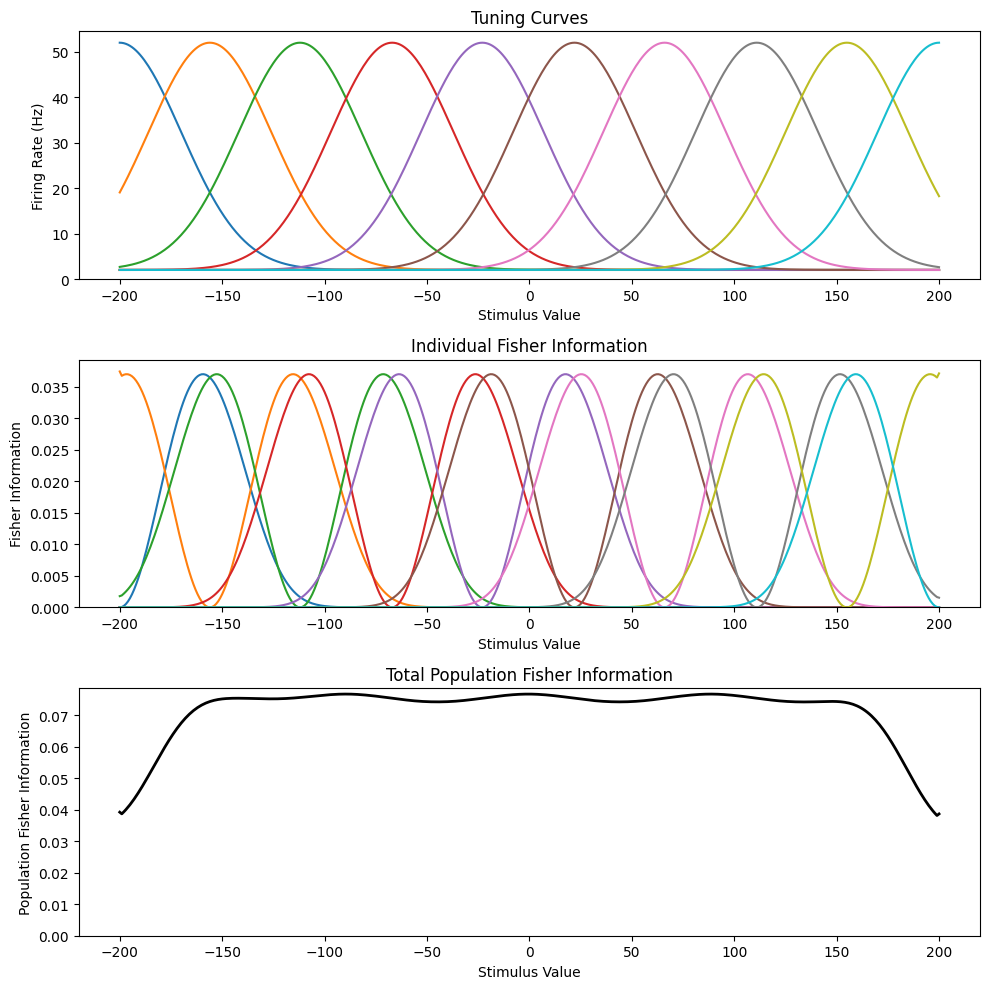

In [2]:
# Create population
n_neurons = 10
pop = GaussianTunedPopulation(n_neurons=n_neurons, reference_rate=50.0, reference_sigma=30.0)

# Set up stimulus grid
stimulus_grid = np.linspace(-200, 200, 401)

# Configure population
pop.set_means_uniform(stimulus_grid)
pop.set_sigmas(30.0)
pop.set_spontaneous_rates(2.0)

# Build curves on the grid
pop.build_tuning_curves(stimulus_grid)
pop.build_fisher_info_curves(epsilon=1e-10)

# Now query at specific points (works for single values!)
single_stimulus = 50.0
single_rates = pop.get_rates_at(single_stimulus)
single_fi = pop.get_population_fisher_info_at(single_stimulus)

print(f"At stimulus = {single_stimulus}:")
print(f"Rates: {single_rates}")
print(f"Population FI: {single_fi:.4f}")

# Plot using stored curves (access TsdFrame correctly)
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

# Tuning curves - access TsdFrame columns
for i in range(n_neurons):
    axes[0].plot(stimulus_grid, pop.tuning_curves.values[:, i])
axes[0].set_xlabel("Stimulus Value")
axes[0].set_ylabel("Firing Rate (Hz)")
axes[0].set_title("Tuning Curves")
axes[0].set_ylim(bottom=0)

# Individual FI - access TsdFrame columns
for i in range(n_neurons):
    axes[1].plot(stimulus_grid, pop.fisher_info_curves.values[:, i])
axes[1].set_xlabel("Stimulus Value")
axes[1].set_ylabel("Fisher Information")
axes[1].set_title("Individual Fisher Information")
axes[1].set_ylim(bottom=0)

# Population FI - sum across neurons (axis 1)
pop_fi_curve = np.sum(pop.fisher_info_curves.values, axis=1)
axes[2].plot(stimulus_grid, pop_fi_curve, "k", linewidth=2)
axes[2].set_xlabel("Stimulus Value")
axes[2].set_ylabel("Population Fisher Information")
axes[2].set_title("Total Population Fisher Information")
axes[2].set_ylim(bottom=0)

plt.tight_layout()
plt.show()

C:\Users\MainUser\Documents\GitHub\neurostatsmodels\neurostatsmodels\populations.py:341: UserWarning: Some starts and ends are equal. Removing 1 microsecond!
  trial_epochs = nap.IntervalSet(


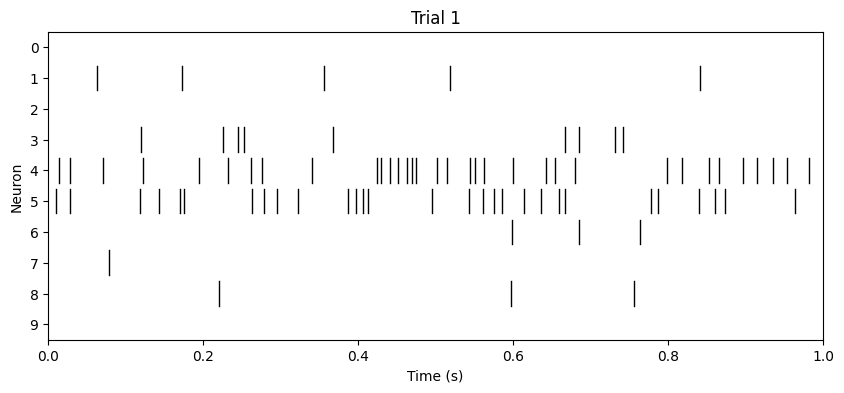

In [3]:
from neurostatsmodels.populations import GaussianTunedPopulation
from neurostatsmodels.plotting import plot_spike_raster

# Generate spikes (returns TsGroup)
pop = GaussianTunedPopulation(n_neurons=10, reference_rate=50., reference_sigma=30)
pop.set_means_uniform(np.linspace(-200, 200, 100))
pop.set_sigmas(30.0)
pop.set_refractory_periods(0.005)
pop.set_spontaneous_rates(2.0)
spikes = pop.generate_spikes(0.0, duration=1.0, n_trials=2)

# Plot trial 1 using new API
fig, ax = plot_spike_raster(spikes, trial_idx=1, title="Trial 1")

Bias: 0.24, Std: 4.41


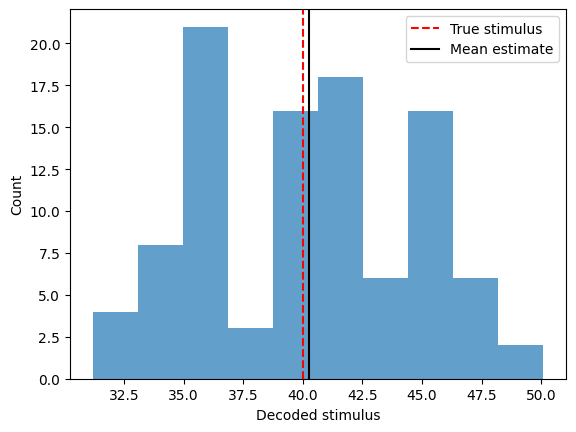

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from neurostatsmodels.populations import GaussianTunedPopulation

# Create population
pop = GaussianTunedPopulation(n_neurons=10, reference_rate=50.0, reference_sigma=30.0)
pop.set_means_uniform(np.linspace(-200, 200, 100))
pop.set_sigmas(50.0)
pop.set_spontaneous_rates(2.0)
pop.set_refractory_periods(0.01)

# Generate spikes at true stimulus = 0 (returns TsGroup)
true_stimulus = 40.0
spikes = pop.generate_spikes(true_stimulus, duration=3.0, n_trials=100)
# Decode each trial using new API (no duration parameter)
s_hat = pop.decode_mle(spikes)

# Analyze bias and spread
bias = np.mean(s_hat) - true_stimulus
std = np.std(s_hat)
print(f"Bias: {bias:.2f}, Std: {std:.2f}")

# Plot histogram
plt.hist(s_hat, bins=10, alpha=0.7)
plt.axvline(true_stimulus, color='r', linestyle='--', label='True stimulus')
plt.axvline(np.mean(s_hat), color='k', linestyle='-', label='Mean estimate')
plt.xlabel('Decoded stimulus')
plt.ylabel('Count')
plt.legend()
plt.show()

#### Optimize ITD decoding performance under firing rate budget using MLE decoder (varying sigma)

In [30]:
import numpy as np
from scipy.optimize import minimize
from neurostatsmodels.populations import GaussianTunedPopulation

# Fixed parameters
n_neurons = 10
reference_rate = 50.0  # Hz, same for all neurons
reference_sigma = 30.0  # Hz, same for all neurons
spontaneous_rate = 3.0  # Hz, baseline firing rate
refractory_period = 0.005  # 5 ms refractory period
itd_range = (-200, 200)  # microseconds
n_itd_steps = 401
rate_budget = 500.0  # Total average firing rate across population (Hz)

# ITD range in microseconds
itd_min, itd_max = itd_range
itd_grid = np.linspace(itd_min, itd_max, n_itd_steps)

# Initialize population
pop = GaussianTunedPopulation(
    n_neurons=n_neurons, reference_rate=reference_rate, reference_sigma=reference_sigma
)

# Set fixed parameters
pop.set_spontaneous_rates(spontaneous_rate)
pop.set_refractory_periods(refractory_period)

# Distribute neuron means uniformly across ITD range
pop.set_means_uniform(itd_grid)

print(f"Population setup:")
print(f"  Neurons: {n_neurons}")
print(f"  Reference rate: {reference_rate} Hz")
print(f"  Reference sigma: {reference_sigma} Hz")
print(f"  Spontaneous rate: {spontaneous_rate} Hz")
print(f"  Refractory period: {refractory_period*1000} ms")
print(f"  ITD range: {itd_min} to {itd_max} μs")
print(f"  Rate budget: {rate_budget} Hz")
print(f"  Neuron preferred ITDs: {pop.means}")
print()


def objective_and_constraint(
    sigma, n_test_stimuli=10, n_trials_per_stim=100, trial_duration=5.0, random_seed=42
):
    """
    Compute MSE from MLE decoding and rate constraint violation.

    Parameters
    ----------
    sigma : float
        Tuning curve width shared for all neurons.
    n_test_stimuli : int
        Number of test ITD values to sample.
    n_trials_per_stim : int
        Number of trials per stimulus for decoding.
    trial_duration : float
        Duration of each trial in seconds.
    random_seed : int
        Random seed for reproducibility.

    Returns
    -------
    mse : float
        Mean squared error of MLE decoder predictions.
    rate_violation : float
        Constraint violation (should be <= 0).
    """
    # Set sigmas
    if np.isscalar(sigma):
        pop.set_sigmas(sigma)
    else:
        pop.set_sigmas(sigma[0])

    # Build tuning curves for decoding
    pop.build_tuning_curves(itd_grid)

    # Sample test ITD values uniformly from range
    rng = np.random.default_rng(random_seed)
    test_itds = rng.uniform(itd_min, itd_max, n_test_stimuli)

    # Generate spikes and decode for each test ITD
    squared_errors = []
    spreads = []

    for true_itd in test_itds:
        # Generate spikes for this ITD
        spikes = pop.generate_spikes(
            stimulus=true_itd,
            duration=trial_duration,
            n_trials=n_trials_per_stim,
            random_state=rng,
        )

        # Decode using MLE
        decoded_itds = pop.decode_mle(spikes, stimulus_range=itd_range)

        # Compute squared errors for all trials
        squared_errors.append((decoded_itds - true_itd) ** 2)
        spreads.append(np.std(decoded_itds))
    
    # Compute MSE
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    avg_spread = np.mean(spreads)

    objective = rmse + avg_spread
    # Compute average firing rate across population and ITD range
    rates = pop.compute_rates(itd_grid)  # shape: (n_neurons, n_itd)
    avg_rate_per_neuron = np.mean(rates, axis=1)  # average over ITD
    total_avg_rate = np.sum(avg_rate_per_neuron)  # sum over neurons

    # if total_avg_rate > rate_budget, then constraint is negative (violation)
    # if total_avg_rate < rate_budget, then constraint is positive (not violated)
    constraint = rate_budget - total_avg_rate

    # Return objective and constraint violation
    return objective, constraint


def objective(sigma):
    """Objective function: MSE from MLE decoding."""
    objective, _ = objective_and_constraint(sigma)
    return objective


def constraint_func(sigma):
    """Constraint function: rate budget - total rate (should be >= 0)."""
    _, constraint = objective_and_constraint(sigma)
    return constraint  # scipy expects constraint >= 0 (not violated)


# Initial guess: uniform sigmas
sigma_init = 50

# Bounds: sigmas must be positive and reasonable
sigma_bounds = [(1.0, 200.0)]

# Constraint: total average firing rate <= rate_budget
constraints = {"type": "ineq", "fun": constraint_func}

print("Starting optimization...")
print(f"Initial sigma: {sigma_init}")

# Evaluate initial objective
print("Evaluating initial objective (this may take a moment)...")
initial_objective, _ = objective_and_constraint(sigma_init)
pop.set_sigmas(sigma_init)
initial_rate = np.sum(np.mean(pop.compute_rates(itd_grid), axis=1))

print(f"Initial objective: {initial_objective:.2f}")
print(f"Initial total rate: {initial_rate:.2f} Hz")
print()

# Optimize
result = minimize(
    objective,
    sigma_init,
    method="COBYLA",
    bounds=sigma_bounds,
    constraints=constraints,
    options={"maxiter": 200, "disp": True},
)

print("Optimization complete!")
print(f"Success: {result.success}")
print(f"Message: {result.message}")
# print(f"Iterations: {result.nit}")
print()

# Extract optimal sigma
optimal_sigma = result.x[0]

# Evaluate final objective
print("Evaluating final objective...")
final_objective, _ = objective_and_constraint(optimal_sigma)
pop.set_sigmas(optimal_sigma)
final_rate = np.sum(np.mean(pop.compute_rates(itd_grid), axis=1))

print(f"Optimal sigma: {optimal_sigma}")
print(f"Final objective: {final_objective:.2f}")
print(f"Final total rate: {final_rate:.2f} Hz")
print(f"Objective improvement: {(1 - final_objective/initial_objective)*100:.2f}%")
print()

# Display results
print("Neuron-by-neuron summary:")
print(f"{'Neuron':<8} {'Mean (μs)':<12} {'Sigma (μs)':<12} {'Avg Rate (Hz)':<15}")
print("-" * 50)
rates = pop.compute_rates(itd_grid)
for i in range(n_neurons):
    avg_rate = np.mean(rates[i, :])
    print(f"{i:<8} {pop.means[i]:<12.2f} {optimal_sigma:<12.2f} {avg_rate:<15.2f}")

print()
print(f"Total average rate: {final_rate:.2f} Hz (budget: {rate_budget} Hz)")
print(f"Decoding objective: {final_objective:.2f}")

Population setup:
  Neurons: 10
  Reference rate: 50.0 Hz
  Reference sigma: 30.0 Hz
  Spontaneous rate: 3.0 Hz
  Refractory period: 5.0 ms
  ITD range: -200 to 200 μs
  Rate budget: 500.0 Hz
  Neuron preferred ITDs: [-200. -156. -112.  -67.  -23.   22.   66.  111.  155.  200.]

Starting optimization...
Initial sigma: 50
Evaluating initial objective (this may take a moment)...
Initial objective: 6.93
Initial total rate: 110.23 Hz

Return from COBYLA because the trust region radius reaches its lower bound.
Number of function values = 37   Least value of F = 3.119556550891234   Constraint violation = 0.0
The corresponding X is: [25.725]
The constraint value is:
[ -24.725      -174.275      -386.22469653]

Optimization complete!
Success: True
Message: Return from COBYLA because the trust region radius reaches its lower bound.

Evaluating final objective...
Optimal sigma: 25.724999999999998
Final objective: 3.12
Final total rate: 113.78 Hz
Objective improvement: 55.01%

Neuron-by-neuron su